# Analyzis of the benchmark

Usually, the analyzis of a benchmark has multiple aspects, which are best split into multiple notebooks.
In this case, the analyzis is very simple, so we only have a single one and also no plots.
We could create separate notebooks for solution quality and runtime.

In [24]:
import pandas as pd

results = pd.read_json("./06_simplified_results.json.zip")
results["interchange"] = results["interchange"].apply(lambda x: x==1)  # Making interchange boolean
results

,instance,strategy,interchange,colors,runtime,num_vertices,num_edges
0,graph_0,largest_first,True,9,0.002952,68,697
1,graph_0,largest_first,False,10,0.000183,68,697
2,graph_0,random_sequential,True,9,0.003562,68,697
3,graph_0,random_sequential,False,12,0.000173,68,697
4,graph_0,smallest_last,True,9,0.003813,68,697
...,...,...,...,...,...,...,...
5995,graph_499,connected_sequential_bfs,True,3,0.000216,16,24
5996,graph_499,connected_sequential_bfs,False,3,0.000132,16,24
5997,graph_499,connected_sequential_dfs,True,3,0.000231,16,24
5998,graph_499,connected_sequential_dfs,False,4,0.000132,16,24


In [25]:
# get the best solutions to get the relative quality
best_coloring = results.groupby("instance")[["colors"]].min()
best_coloring

,colors
instance,
graph_0,9
graph_1,48
graph_10,18
graph_100,7
graph_101,24
...,...
graph_95,67
graph_96,4
graph_97,28


In [26]:
# compute how many % above the best solution the corresponding solutions are
t = pd.merge(left=results, right=best_coloring, on="instance", suffixes=("", "_best"))
t["above_best (%)"] = (t["colors"] / t["colors_best"] - 1) * 100

In [27]:
# show the means for each algorithm
t.groupby(["strategy", "interchange"], dropna=False)[
    ["above_best (%)", "runtime"]
].mean()

above_best (%)   runtime
strategy                 interchange                          
connected_sequential_bfs False             21.721071  0.007044
                         True               5.853882  0.117117
connected_sequential_dfs False             21.310712  0.006954
                         True               6.353801  0.118031
independent_set          False             12.994506  0.138510
largest_first            False             13.385585  0.000909
                         True               1.691595  0.100657
random_sequential        False             21.637301  0.000897
                         True               6.564790  0.111941
saturation_largest_first False              4.460664  0.099271
smallest_last            False             15.243594  0.016162
                         True               1.869048  0.118496

It seems like the strategy `smallest_last` with the option `interchange=True` creates on average the best solutions for the benchmark instances.

## Runtime Analysis

In [28]:
import seaborn as sns

sns.set_theme()  # making the plot pretty by default

<AxesSubplot: xlabel='num_vertices', ylabel='runtime'>

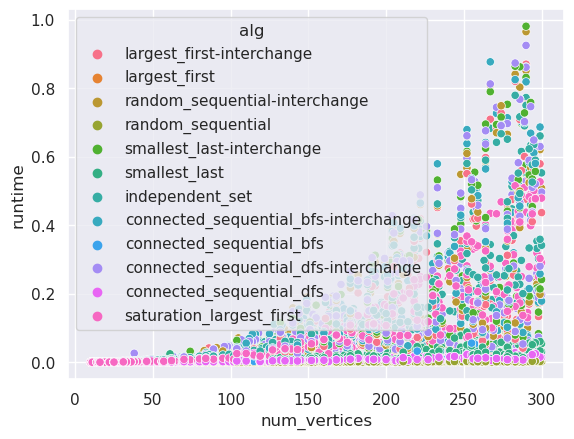

In [29]:

# Let us first to a trivial scatter plot to get a fist view on the data.

# name the alg for the legend.
t["alg"] = t.apply((lambda row: row['strategy']+("-interchange" if row['interchange'] else "")), axis=1)
# plot the data
sns.scatterplot(data=t, # the data to plot
                 x="num_vertices",  # the number of vertices on the x-axis
                   y="runtime",  # the runtime on the y-axis
                     hue="alg"  # Every algorithm in a different color
                     ) 

As wen can see, we cannot see much as there are too many data points. Let us reduce this by
- looking only on a few strategies.
- aggregating the data.

The most interesting part seems to be 250-300 vertices, so let us first look here to see what could be interesting.

<AxesSubplot: xlabel='num_vertices', ylabel='runtime'>

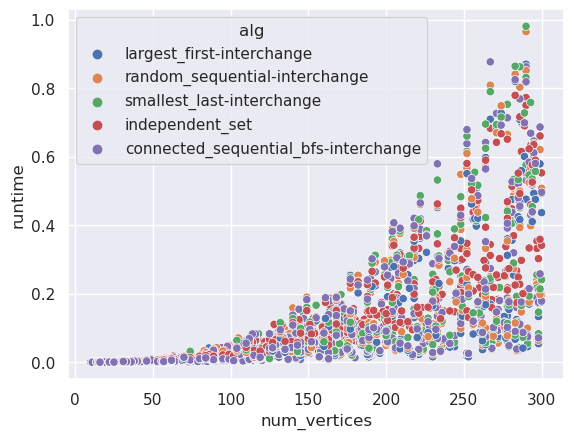

In [38]:
best_five = t.nsmallest(5, columns="above_best (%)")["alg"].to_list()
sns.scatterplot(t[t["alg"].isin(best_five)], x="num_vertices", y="runtime", hue="alg")

<AxesSubplot: xlabel='num_vertices', ylabel='runtime'>

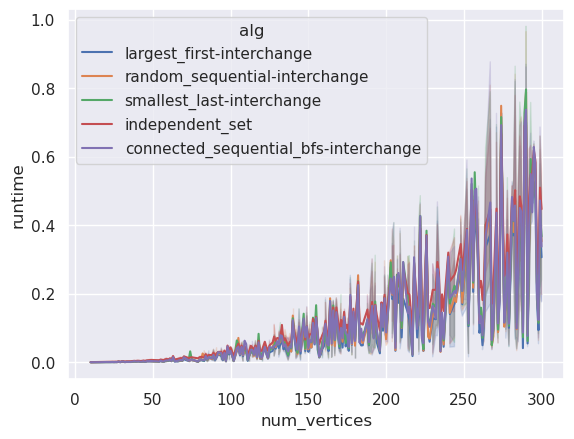

In [40]:

sns.lineplot(t[t["alg"].isin(best_five)], x="num_vertices", y="runtime", hue="alg")

<AxesSubplot: xlabel='num_vertices_rounded', ylabel='runtime'>

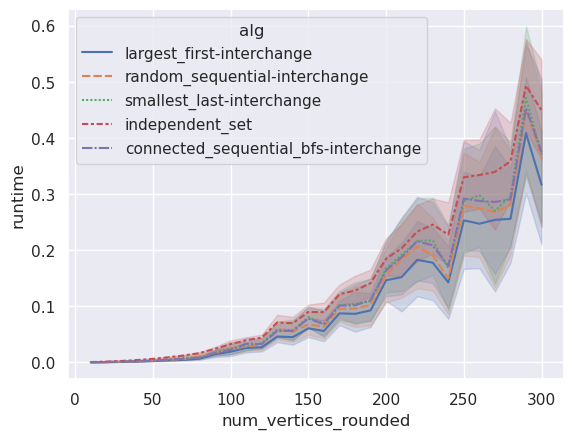

In [43]:
t["num_vertices_rounded"] = t["num_vertices"].apply(lambda x: (10*round(x/10)))
sns.lineplot(t[t["alg"].isin(best_five)], x="num_vertices_rounded", y="runtime", hue="alg", style="alg")

<AxesSubplot: xlabel='num_vertices_rounded', ylabel='above_best (%)'>

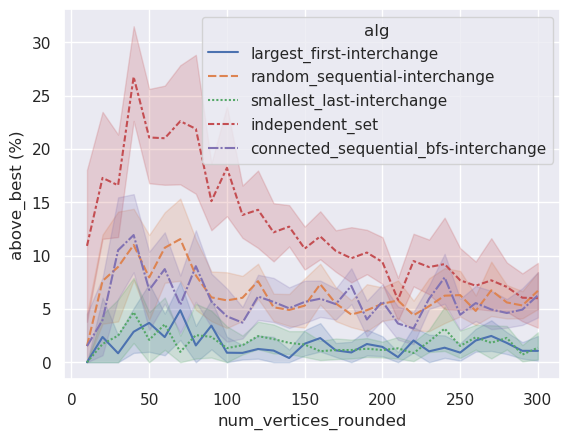

In [44]:
t["num_vertices_rounded"] = t["num_vertices"].apply(lambda x: (10*round(x/10)))
sns.lineplot(t[t["alg"].isin(best_five)], x="num_vertices_rounded", y="above_best (%)", hue="alg", style="alg")